In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

1. ИНИЦИАЛИЗАЦИЯ ГЕНЕРАТОРА ПОСЛЕДОВАТЕЛЬНОСТИ
Загрузка данных из: C:\data
Загружено 21 символов, всего 225291 изображений

------------------------------------------------------------
ГЕНЕРАЦИЯ ТЕСТОВОЙ ПОСЛЕДОВАТЕЛЬНОСТИ
------------------------------------------------------------

Генерация последовательности из 10 символов...
Сгенерировано: 4 9 - ( 3 5 w 0 3 3


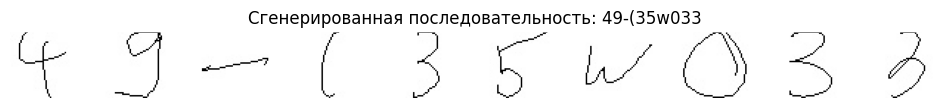

In [12]:
# ====================== 1. ГЕНЕРАТОР ПОСЛЕДОВАТЕЛЬНОСТИ ======================
print("="*60)
print("1. ИНИЦИАЛИЗАЦИЯ ГЕНЕРАТОРА ПОСЛЕДОВАТЕЛЬНОСТИ")
print("="*60)

class HandwrittenSymbolsGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self._load_symbols()
    
    def _load_symbols(self):
        folders = [f for f in os.listdir(self.data_path) 
                  if os.path.isdir(os.path.join(self.data_path, f))]
        
        total_images = 0
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []
            
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)
            
            self.symbols_data[folder] = images
            total_images += len(images)
        
        print(f"Загружено {len(folders)} символов, всего {total_images} изображений")
    def generate_sequence(self, length=10):
        symbols = list(self.symbols_data.keys())
        sequence_images = []
        labels = []
        
        print(f"\nГенерация последовательности из {length} символов...")
        
        for i in range(length):
            symbol = random.choice(symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)
        
        sequence_image = self.create_sequence_image(sequence_images)
        sequence_text = ''.join(labels)
        
        print(f"Сгенерировано: {' '.join(labels)}")
        
        return {
            'sequence_images': sequence_images,
            'sequence_image': sequence_image,
            'labels': labels,
            'sequence_text': sequence_text,
            'length': length
        }
    
    def create_sequence_image(self, images, spacing=20):
        processed_images = []
        for img in images:
            processed_images.append(img)

        total_width = sum(img.shape[1] for img in processed_images) + spacing * (len(processed_images) - 1)
        max_height = max(img.shape[0] for img in processed_images)
        
        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in processed_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + spacing
        
        return sequence_img
    
    def display_sequence(self, sequence_data, title="Сгенерированная последовательность"):
        plt.figure(figsize=(12, 3))
        plt.imshow(sequence_data['sequence_image'], cmap='gray')
        plt.title(f"{title}: {sequence_data['sequence_text']}")
        plt.axis('off')
        plt.show()

# Инициализация генератора
DATA_PATH = 'C:\\data'
print(f"Загрузка данных из: {DATA_PATH}")
generator = HandwrittenSymbolsGenerator(DATA_PATH)

# Генерация тестовой последовательности
print("\n" + "-"*60)
print("ГЕНЕРАЦИЯ ТЕСТОВОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
print("-"*60)
sequence_data = generator.generate_sequence(length=10)
generator.display_sequence(sequence_data)


2. СЕГМЕНТАЦИЯ СИМВОЛОВ ИЗ ПОСЛЕДОВАТЕЛЬНОСТИ
Обрабатываем последовательность: 4 9 - ( 3 5 w 0 3 3
Символы без пробелов: ['4', '9', '-', '(', '3', '5', 'w', '0', '3', '3']


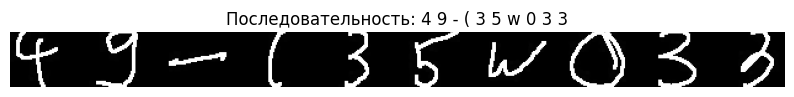

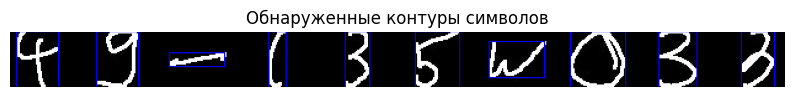

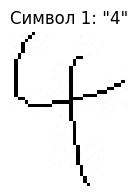

Символ 1: '4' 


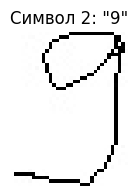

Символ 2: '9' 


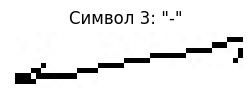

Символ 3: '-' 


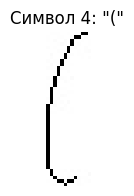

Символ 4: '(' 


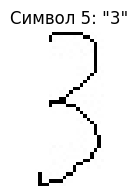

Символ 5: '3' 


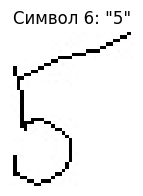

Символ 6: '5' 


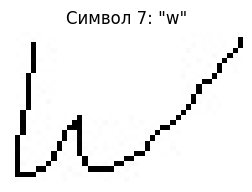

Символ 7: 'w' 


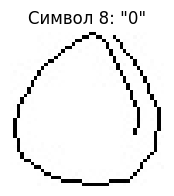

Символ 8: '0' 


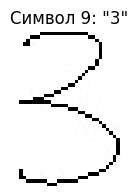

Символ 9: '3' 


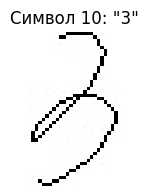

Символ 10: '3' 

Итог: сегментировано 10 символов


In [13]:
# ====================== 2. СЕГМЕНТАЦИЯ СИМВОЛОВ ======================
print("\n" + "="*60)
print("2. СЕГМЕНТАЦИЯ СИМВОЛОВ ИЗ ПОСЛЕДОВАТЕЛЬНОСТИ")
print("="*60)

class SequenceSegmenter:
    def segment_sequence(self, sequence_image, original_labels):
        print(f"Обрабатываем последовательность: {' '.join(original_labels)}")
        
        non_space_labels = [label for label in original_labels if label != ' ']
        print(f"Символы без пробелов: {non_space_labels}")

        # Бинаризация и обработка
        img_gray = sequence_image
        kernel = np.ones((3,3),np.uint8)
        img_gray = cv2.erode(img_gray,kernel,iterations = 1)
        img_gray = cv2.bitwise_not(img_gray)
        
        base_size = img_gray.shape[0], img_gray.shape[1]
        base = np.zeros(base_size, dtype=np.uint8)
        base[0:img_gray.shape[0], 0:img_gray.shape[1]] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

        plt.figure(figsize=(10, 3))
        plt.imshow(base)
        plt.title(f'Последовательность: {" ".join(original_labels)}')
        plt.axis('off')
        plt.show()

        ret, thresh = cv2.threshold(base, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
        
        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = base.copy()

        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i] 
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Обнаруженные контуры символов')
        plt.axis('off')
        plt.show()

        sequence_symbols = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]
            
            img_crop = sequence_image[y:y+h, x:x+w]
            
            if i < len(non_space_labels):
                symbol_label = non_space_labels[i]
            else:
                symbol_label = "?"
                
            plt.figure(figsize=(3, 2))
            plt.imshow(img_crop, cmap="gray")
            plt.title(f'Символ {i+1}: "{symbol_label}"')
            plt.axis('off')
            plt.show()
            
            sequence_symbols.append((symbol_label, img_crop))
            print(f"Символ {i+1}: '{symbol_label}' ")

        return sequence_symbols

# Сегментация последовательности
original_labels = sequence_data['labels']
sequence_image = sequence_data['sequence_image']

segmenter = SequenceSegmenter()
segmented_symbols = segmenter.segment_sequence(sequence_image, original_labels)
print(f"\nИтог: сегментировано {len(segmented_symbols)} символов")

In [14]:
# ====================== 3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ ======================
print("\n" + "="*60)
print("3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ KNN")
print("="*60)

def center_in_45(image, target_size=45):
    h, w = image.shape
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    print("Загрузка данных для обучения...")
    
    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
  
        images = [f for f in os.listdir(symbol_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()
         
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        test_images = images[split_idx:]
        
        print(f"  Символ '{symbol}': {len(train_images)} обучающих, {len(test_images)} тестовых")
        
        # Обучающие данные
        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(symbol)
        
        # Тестовые данные
        for img_name in test_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_test.append(img_resized.flatten())
                y_test.append(symbol)
    
    print(f"\nОбучающая выборка: {len(X_train)} изображений")
    print(f"Тестовая выборка: {len(X_test)} изображений")
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Загрузка данных
symbols = ['0','1','2','3','4','5','6','7','8','9','+','-','times','t','X','y','w','h','(',')',',']
X_train, y_train, X_test, y_test = load_training_data(DATA_PATH, symbols, train_size=0.8)


3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ KNN
Загрузка данных для обучения...
  Символ '0': 5531 обучающих, 1383 тестовых
  Символ '1': 21216 обучающих, 5304 тестовых
  Символ '2': 20912 обучающих, 5229 тестовых
  Символ '3': 8727 обучающих, 2182 тестовых
  Символ '4': 5916 обучающих, 1480 тестовых
  Символ '5': 2836 обучающих, 709 тестовых
  Символ '6': 2494 обучающих, 624 тестовых
  Символ '7': 2327 обучающих, 582 тестовых
  Символ '8': 2454 обучающих, 614 тестовых
  Символ '9': 502 обучающих, 126 тестовых
  Символ '+': 20089 обучающих, 5023 тестовых
  Символ '-': 27197 обучающих, 6800 тестовых
  Символ 'times': 2600 обучающих, 651 тестовых
  Символ 't': 2619 обучающих, 655 тестовых
  Символ 'X': 21275 обучающих, 5319 тестовых
  Символ 'y': 7472 обучающих, 1868 тестовых
  Символ 'w': 444 обучающих, 112 тестовых
  Символ 'h': 1171 обучающих, 293 тестовых
  Символ '(': 11435 обучающих, 2859 тестовых
  Символ ')': 11484 обучающих, 2871 тестовых
  Символ ',': 1524 обучающих, 382 тестовых

Обуча

In [15]:
# ====================== 4. ОБУЧЕНИЕ МОДЕЛЕЙ KNN ======================
print("\n" + "="*60)
print("4. ОБУЧЕНИЕ МОДЕЛЕЙ KNN С РАЗНЫМИ ПАРАМЕТРАМИ")
print("="*60)

# Обучение моделей с разными k
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
print("✅ KNN с k=1 обучен")

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
print("✅ KNN с k=3 обучен")

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
print("✅ KNN с k=5 обучен")

knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, y_train)
print("✅ KNN с k=7 обучен")

print("\nВсе модели успешно обучены!")


4. ОБУЧЕНИЕ МОДЕЛЕЙ KNN С РАЗНЫМИ ПАРАМЕТРАМИ
✅ KNN с k=1 обучен
✅ KNN с k=3 обучен
✅ KNN с k=5 обучен
✅ KNN с k=7 обучен

Все модели успешно обучены!


In [16]:
# ====================== 5. ОЦЕНКА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ ======================
print("\n" + "="*60)
print("5. ОЦЕНКА ТОЧНОСТИ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)

models = {
    'knn1': knn1,
    'knn3': knn3, 
    'knn5': knn5,
    'knn7': knn7
}

test_results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_results[model_name] = accuracy
    print(f"{model_name}: точность = {accuracy:.2%}")

# Определение лучшей модели на тестовой выборке
best_model_name = max(test_results, key=test_results.get)
best_model = models[best_model_name]
best_accuracy = test_results[best_model_name]

print(f"\nЛучшая модель на тестовой выборке: {best_model_name}")
print(f"Точность лучшей модели: {best_accuracy:.2%}")

# Подробный отчет для лучшей модели
print(f"\nПодробный отчет классификации для {best_model_name}:")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best, zero_division=0))


5. ОЦЕНКА ТОЧНОСТИ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ
knn1: точность = 99.55%
knn3: точность = 83.20%
knn5: точность = 77.21%
knn7: точность = 69.15%

Лучшая модель на тестовой выборке: knn1
Точность лучшей модели: 99.55%

Подробный отчет классификации для knn1:
              precision    recall  f1-score   support

           (       1.00      1.00      1.00      2859
           )       0.98      1.00      0.99      2871
           +       1.00      1.00      1.00      5023
           ,       0.94      0.84      0.89       382
           -       1.00      1.00      1.00      6800
           0       1.00      1.00      1.00      1383
           1       0.99      1.00      0.99      5304
           2       1.00      1.00      1.00      5229
           3       1.00      1.00      1.00      2182
           4       1.00      1.00      1.00      1480
           5       1.00      1.00      1.00       709
           6       1.00      1.00      1.00       624
           7       1.00      1.00      1


6. ПОДГОТОВКА СЕГМЕНТИРОВАННЫХ СИМВОЛОВ ДЛЯ КЛАССИФИКАЦИИ
Обработка сегментированных символов...
Обработано 10 символов

ОБРАБОТАННЫЕ СИМВОЛЫ:


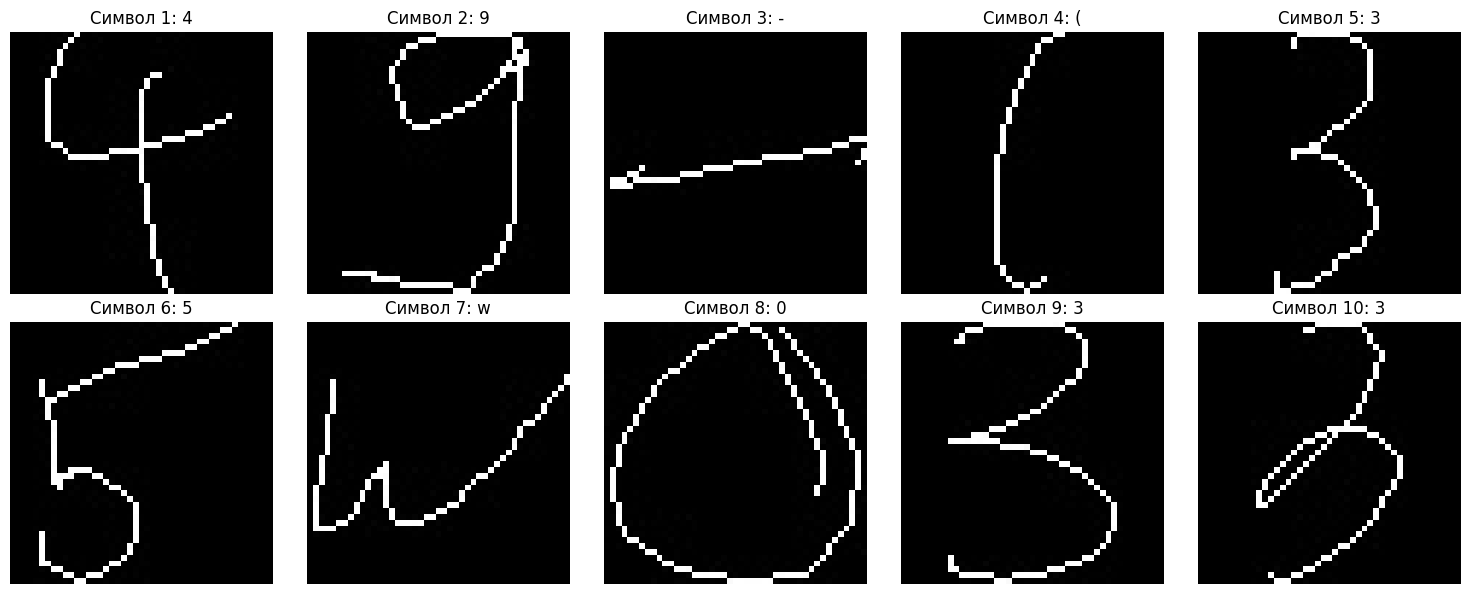

In [17]:
# ====================== 6. ОБРАБОТКА СЕГМЕНТИРОВАННЫХ СИМВОЛОВ ======================
print("\n" + "="*60)
print("6. ПОДГОТОВКА СЕГМЕНТИРОВАННЫХ СИМВОЛОВ ДЛЯ КЛАССИФИКАЦИИ")
print("="*60)

# Подготовка сегментированных символов
resized_symbols = []
print("Обработка сегментированных символов...")

for true_label, symbol_img in segmented_symbols:
    processed_img = cv2.bitwise_not(symbol_img)
    resized_img = center_in_45(processed_img)
    resized_symbols.append((true_label, resized_img))

print(f"Обработано {len(resized_symbols)} символов")

# Отображение обработанных символов
print("\nОБРАБОТАННЫЕ СИМВОЛЫ:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for j, (true_label, symbol_img) in enumerate(resized_symbols):
    if j < 10:
        axes[j].imshow(symbol_img, cmap='gray')
        axes[j].set_title(f'Символ {j+1}: {true_label}')
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# ====================== 7. КЛАССИФИКАЦИЯ СИМВОЛОВ РАЗНЫМИ МОДЕЛЯМИ ======================
print("\n" + "="*60)
print("7. КЛАССИФИКАЦИЯ СИМВОЛОВ РАЗНЫМИ МОДЕЛЯМИ KNN")
print("="*60)

results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    predicted_symbols = []
    
    for j, (true_label, symbol_img) in enumerate(resized_symbols):
        img_flat = symbol_img.flatten()
        predicted_char = model.predict([img_flat])[0]
        predicted_symbols.append(predicted_char)
        print(f"    Символ {j+1}: ожидалось '{true_label}', предсказан '{predicted_char}'")
    
    predicted_text = ''.join(predicted_symbols)
    print(f"Предсказано: '{predicted_text}'")
    
    original_text_str = sequence_data['sequence_text']
    
    correct_chars = sum(1 for orig, pred in zip(original_text_str, predicted_text) if orig == pred)
    total_chars = len(original_text_str)
    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    
    if original_text_str != predicted_text:
        for idx, (orig_char, pred_char) in enumerate(zip(original_text_str, predicted_text)):
            if orig_char != pred_char:
                print(f"   Ошибка в позиции {idx+1}: ожидалось '{orig_char}', получено '{pred_char}'")
    
    print(f"Accuracy для {model_name}: {accuracy:.2f} ({correct_chars}/{total_chars} символов)")
    
    results[model_name] = {
        'predicted_text': predicted_text,
        'accuracy': accuracy,
        'correct_chars': correct_chars,
        'total_chars': total_chars
    }



7. КЛАССИФИКАЦИЯ СИМВОЛОВ РАЗНЫМИ МОДЕЛЯМИ KNN

МОДЕЛЬ: knn1
    Символ 1: ожидалось '4', предсказан '4'
    Символ 2: ожидалось '9', предсказан '9'
    Символ 3: ожидалось '-', предсказан '-'
    Символ 4: ожидалось '(', предсказан '('
    Символ 5: ожидалось '3', предсказан '3'
    Символ 6: ожидалось '5', предсказан '5'
    Символ 7: ожидалось 'w', предсказан '-'
    Символ 8: ожидалось '0', предсказан '0'
    Символ 9: ожидалось '3', предсказан '3'
    Символ 10: ожидалось '3', предсказан '3'
Предсказано: '49-(35-033'
   Ошибка в позиции 7: ожидалось 'w', получено '-'
Accuracy для knn1: 0.90 (9/10 символов)

МОДЕЛЬ: knn3
    Символ 1: ожидалось '4', предсказан '1'
    Символ 2: ожидалось '9', предсказан '9'
    Символ 3: ожидалось '-', предсказан '-'
    Символ 4: ожидалось '(', предсказан '('
    Символ 5: ожидалось '3', предсказан '3'
    Символ 6: ожидалось '5', предсказан '5'
    Символ 7: ожидалось 'w', предсказан '-'
    Символ 8: ожидалось '0', предсказан '0'
    Символ 9: 


8. ИТОГИ ПО ВСЕМ МОДЕЛЯМ

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
------------------------------------------------------------
knn1  | Accuracy:  90.00% | 9/10 | Предсказание: '49-(35-033'
knn3  | Accuracy:  80.00% | 8/10 | Предсказание: '19-(35-033'
knn5  | Accuracy:  80.00% | 8/10 | Предсказание: '19-(35-033'
knn7  | Accuracy:  50.00% | 5/10 | Предсказание: '19-(31-23,'

ОРИГИНАЛЬНАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ:
'49-(35w033'

9. ДОПОЛНИТЕЛЬНОЕ ТЕСТИРОВАНИЕ НА НОВЫХ ПОСЛЕДОВАТЕЛЬНОСТЯХ
Генерация дополнительных тестовых последовательностей...

--- Тестовая последовательность 1 ---

Генерация последовательности из 8 символов...
Сгенерировано: t 5 ( 6 4 8 1 8


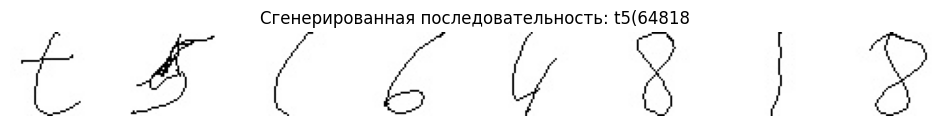


--- Тестовая последовательность 2 ---

Генерация последовательности из 8 символов...
Сгенерировано: 4 X 4 1 - 3 + 3


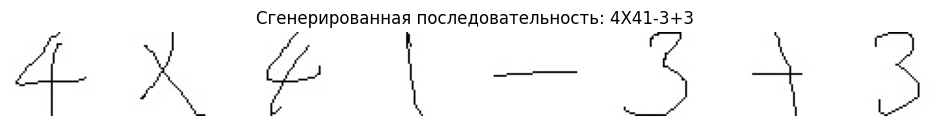


--- Тестовая последовательность 3 ---

Генерация последовательности из 9 символов...
Сгенерировано: 3 3 y 1 3 h y 0 t


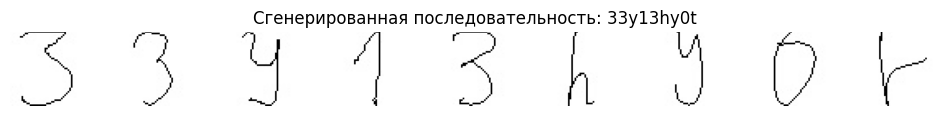


ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ (knn1) НА НОВЫХ ДАННЫХ

Тест 1: 't5(64818'
Обрабатываем последовательность: t 5 ( 6 4 8 1 8
Символы без пробелов: ['t', '5', '(', '6', '4', '8', '1', '8']


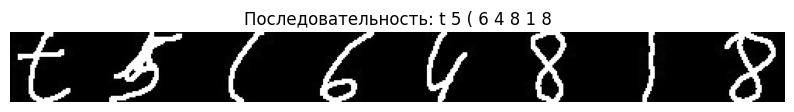

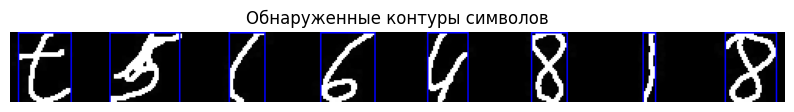

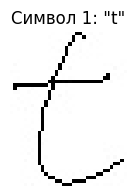

Символ 1: 't' 


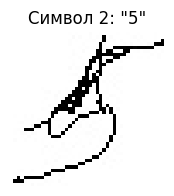

Символ 2: '5' 


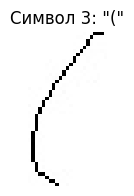

Символ 3: '(' 


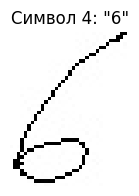

Символ 4: '6' 


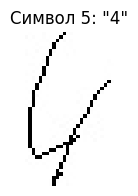

Символ 5: '4' 


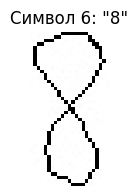

Символ 6: '8' 


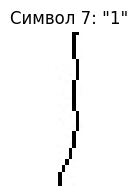

Символ 7: '1' 


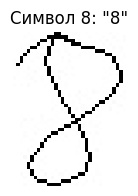

Символ 8: '8' 
  Оригинал:   t5(64818
  Распознано: t5(64818
  Точность:   100.00% (8/8)

Тест 2: '4X41-3+3'
Обрабатываем последовательность: 4 X 4 1 - 3 + 3
Символы без пробелов: ['4', 'X', '4', '1', '-', '3', '+', '3']


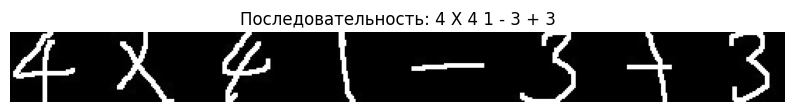

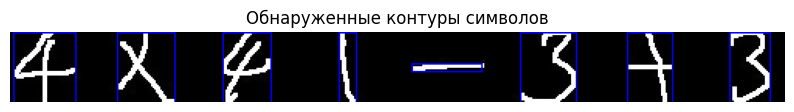

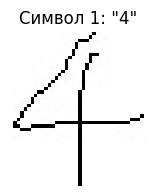

Символ 1: '4' 


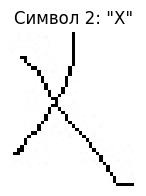

Символ 2: 'X' 


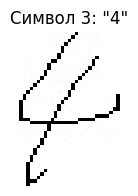

Символ 3: '4' 


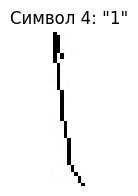

Символ 4: '1' 


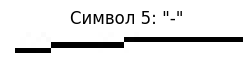

Символ 5: '-' 


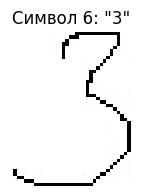

Символ 6: '3' 


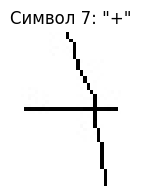

Символ 7: '+' 


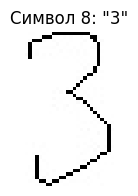

Символ 8: '3' 
  Оригинал:   4X41-3+3
  Распознано: 4X41-3+3
  Точность:   100.00% (8/8)

Тест 3: '33y13hy0t'
Обрабатываем последовательность: 3 3 y 1 3 h y 0 t
Символы без пробелов: ['3', '3', 'y', '1', '3', 'h', 'y', '0', 't']


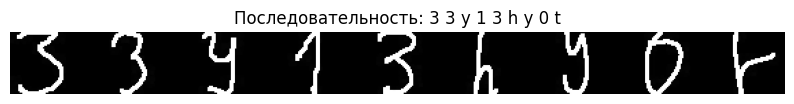

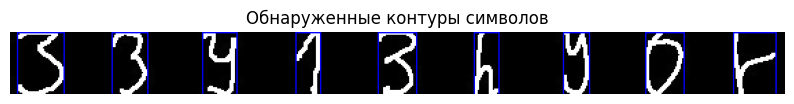

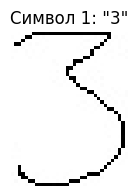

Символ 1: '3' 


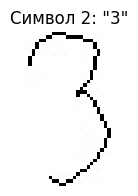

Символ 2: '3' 


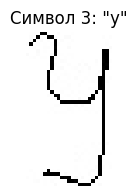

Символ 3: 'y' 


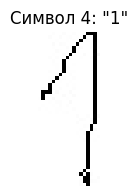

Символ 4: '1' 


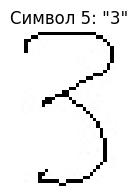

Символ 5: '3' 


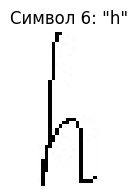

Символ 6: 'h' 


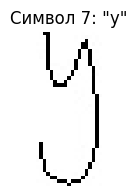

Символ 7: 'y' 


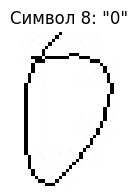

Символ 8: '0' 


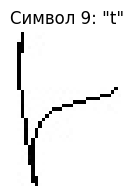

Символ 9: 't' 
  Оригинал:   33y13hy0t
  Распознано: 33y13hy0t
  Точность:   100.00% (9/9)

РАБОТА ЗАВЕРШЕНА!


In [19]:
# ====================== 8. ИТОГИ И СРАВНЕНИЕ МОДЕЛЕЙ ======================
print("\n" + "="*60)
print("8. ИТОГИ ПО ВСЕМ МОДЕЛЯМ")
print("="*60)

print("\nСРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("-" * 60)

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    accuracy_percent = result['accuracy'] * 100
    print(f"{model_name:5} | Accuracy: {accuracy_percent:6.2f}% | {result['correct_chars']}/{result['total_chars']} | Предсказание: '{result['predicted_text']}'")

print("\n" + "="*60)
print("ОРИГИНАЛЬНАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ:")
print(f"'{sequence_data['sequence_text']}'")
print("="*60)

# ====================== 9. ДОПОЛНИТЕЛЬНОЕ ТЕСТИРОВАНИЕ ======================
print("\n" + "="*60)
print("9. ДОПОЛНИТЕЛЬНОЕ ТЕСТИРОВАНИЕ НА НОВЫХ ПОСЛЕДОВАТЕЛЬНОСТЯХ")
print("="*60)

# Генерация еще нескольких последовательностей для тестирования
test_sequences = []

print("Генерация дополнительных тестовых последовательностей...")
for i in range(3):
    print(f"\n--- Тестовая последовательность {i+1} ---")
    seq_data = generator.generate_sequence(length=random.randint(8, 12))
    test_sequences.append(seq_data)
    generator.display_sequence(seq_data)

# Тестирование лучшей модели на новых последовательностях
print("\n" + "="*60)
print(f"ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ ({best_model_name}) НА НОВЫХ ДАННЫХ")
print("="*60)

for i, seq_data in enumerate(test_sequences, 1):
    print(f"\nТест {i}: '{seq_data['sequence_text']}'")
    
    # Сегментация
    segmented = segmenter.segment_sequence(seq_data['sequence_image'], seq_data['labels'])
    
    if not segmented:
        print("  ❌ Не удалось сегментировать символы")
        continue
    
    # Подготовка символов
    prepared_symbols = []
    for label, img in segmented:
        processed_img = cv2.bitwise_not(img)
        resized_img = center_in_45(processed_img)
        prepared_symbols.append((label, resized_img))
    
    # Распознавание
    predicted_chars = []
    for true_label, symbol_img in prepared_symbols:
        img_flat = symbol_img.flatten()
        predicted_char = best_model.predict([img_flat])[0]
        predicted_chars.append(predicted_char)
    
    predicted_text = ''.join(predicted_chars)
    original_text = seq_data['sequence_text']
    
    # Оценка точности
    correct = sum(1 for orig, pred in zip(original_text, predicted_text) if orig == pred)
    accuracy = correct / len(original_text) if len(original_text) > 0 else 0
    
    print(f"  Оригинал:   {original_text}")
    print(f"  Распознано: {predicted_text}")
    print(f"  Точность:   {accuracy:.2%} ({correct}/{len(original_text)})")

print("\n" + "="*60)
print("РАБОТА ЗАВЕРШЕНА!")
print("="*60)